In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from datetime import datetime, timedelta

In [50]:
# Load historical data
data = pd.read_csv('daily-treasury-rates.csv', parse_dates=['Date'], index_col='Date')
data = data['4 WEEKS COUPON EQUIVALENT']
data = data.sort_index()
data

Date
2024-01-02    5.39
2024-01-03    5.38
2024-01-04    5.40
2024-01-05    5.39
2024-01-08    5.39
              ... 
2024-04-17    5.38
2024-04-18    5.38
2024-04-19    5.38
2024-04-22    5.38
2024-04-23    5.38
Name: 4 WEEKS COUPON EQUIVALENT, Length: 78, dtype: float64

In [115]:
weekly_data = data.resample('W-FRI').last()
weekly_data = weekly_data.sort_index()

weekly_data

Date
2024-01-05    5.39
2024-01-12    5.39
2024-01-19    5.39
2024-01-26    5.38
2024-02-02    5.39
2024-02-09    5.39
2024-02-16    5.39
2024-02-23    5.40
2024-03-01    5.40
2024-03-08    5.38
2024-03-15    5.39
2024-03-22    5.37
2024-03-29    5.39
2024-04-05    5.37
2024-04-12    5.38
2024-04-19    5.38
2024-04-26    5.38
Freq: W-FRI, Name: 4 WEEKS COUPON EQUIVALENT, dtype: float64

In [116]:
def ho_lee_params(data):
    # Calculate differences Δr
    delta_r = data.diff().dropna()
    
    # Estimate θ and σ
    theta = delta_r.mean() / (1/52)  # Assuming weekly data
    sigma = delta_r.std() / np.sqrt(1/52)
    return theta, sigma

def vasicek_params(data):
    dt = 1/52  # Weekly time step
    r_diff = data.diff().dropna()
    r_lagged = data.shift(1).dropna()

    def vasicek_loss(params):
        a, b, sigma = params
        dr_pred = a * (b - r_lagged) * dt
        return np.sum((r_diff - dr_pred)**2) + (sigma**2 * dt)

    initial_guess = [0.1, data.mean(), data.std()]
    result = minimize(vasicek_loss, initial_guess, bounds=[(0, None), (None, None), (0, None)])
    return result.x

# Calculate parameters
hl_theta, hl_sigma = ho_lee_params(data)
vas_a, vas_b, vas_sigma = vasicek_params(data)

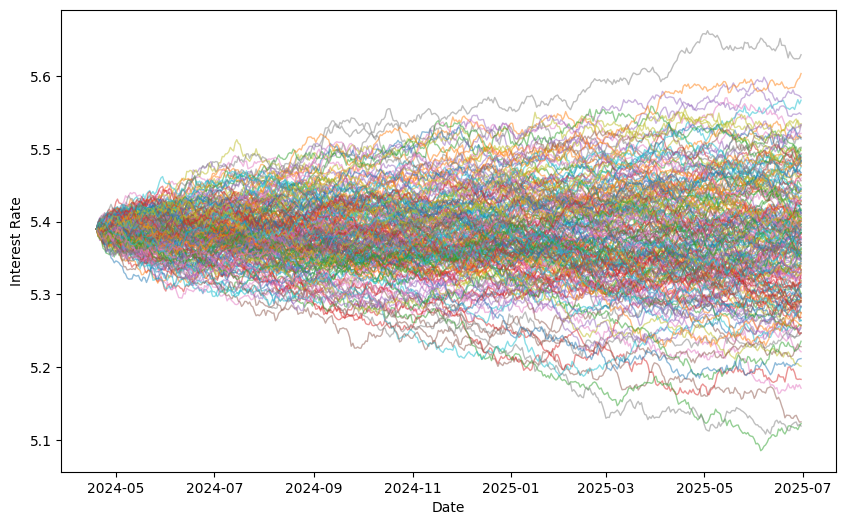

In [119]:
from datetime import datetime

# Define the start and end dates
start_date = datetime.strptime('2024-04-19', '%Y-%m-%d')
end_date = datetime.strptime('2025-06-30', '%Y-%m-%d')

# Calculate the number of weeks between the two dates
num_days = (end_date - start_date).days + 1
# Function to simulate the Ho-Lee interest rate paths
def simulate_ho_lee_paths(r0, theta, sigma, num_days, dt, num_paths):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    rate_paths = np.zeros((num_days, num_paths))

    for path in range(num_paths):
        rates = [r0]
        for _ in range(1, len(dates)):
            dr = theta * dt + sigma * np.sqrt(dt) * np.random.normal()
            rates.append(rates[-1] + dr)
        rate_paths[:, path] = rates

    return pd.DataFrame(rate_paths, index=dates)

dt = 1 / 365
num_paths = 200 
# Simulate the interest rates using the Ho-Lee model
ho_lee_paths = simulate_ho_lee_paths(initial_rate, hl_theta, hl_sigma, num_days, dt, num_paths)
# Plotting the simulated paths
plt.figure(figsize=(10, 6))
for path in ho_lee_paths.columns:
    plt.plot(ho_lee_paths.index, ho_lee_paths[path], lw=1, alpha=0.5)

#plt.title('Simulated Interest Rate Paths Using the Ho-Lee Model')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.show()

In [43]:
hl_rates

2024-04-19    5.390000
2024-04-20    5.391303
2024-04-21    5.397414
2024-04-22    5.400975
2024-04-23    5.400333
                ...   
2025-06-26    5.363402
2025-06-27    5.365943
2025-06-28    5.368273
2025-06-29    5.372755
2025-06-30    5.376217
Freq: D, Length: 438, dtype: float64

In [51]:
last_historical_date = data.index[-1]
last_historical_date

Timestamp('2024-04-23 00:00:00')

In [53]:
last_historical_date = data.index[-1]
trimmed_hl_rates = hl_rates[hl_rates.index > last_historical_date]
combined_rates = pd.concat([data, trimmed_hl_rates])
combined_rates

2024-01-02    5.390000
2024-01-03    5.380000
2024-01-04    5.400000
2024-01-05    5.390000
2024-01-08    5.390000
                ...   
2025-06-26    5.523327
2025-06-27    5.528787
2025-06-28    5.524648
2025-06-29    5.529375
2025-06-30    5.534833
Length: 511, dtype: float64

In [70]:
# Read the simulated stock price data (assumed to be read from your CSV file)
df_stock = pd.read_csv('atr_data_gbm.csv', parse_dates=['Date'])
df_stock.set_index('Date', inplace=True)
df_stock

,High,Low,Close,ATR,Lower_Bound
Date,,,,,
2024-01-02,473.670013,470.489990,472.649994,NaN,NaN
2024-01-03,471.190002,468.170013,468.790009,NaN,NaN
2024-01-04,470.959991,467.049988,467.279999,NaN,NaN
2024-01-05,470.440002,466.429993,467.920013,3.475998,450.540024
2024-01-08,474.750000,468.299988,474.600006,3.744995,455.875031
...,...,...,...,...,...
2025-06-23,526.202438,523.953780,524.003693,1.706360,515.471893
2025-06-24,524.675610,522.844001,523.059306,1.517754,515.470537
2025-06-25,524.624845,522.855541,523.994319,1.584812,516.070260


In [113]:
combined_rates.sort_index(inplace=True)
start_date = '2024-01-01'
end_date = '2025-06-27'
# Fill missing dates in stock data by forward-filling the previous data
df_stock = df_stock.reindex(pd.date_range(start=start_date, end=end_date, freq='D')).ffill().bfill()

# Likewise, fill missing rates using the closest available rate
combined_rates = combined_rates.reindex(pd.date_range(start=start_date, end=end_date, freq='D')).ffill().bfill()

# Define the function for pricing an American put option using a 4-step binomial tree
def binomial_american_put_dynamic(S_high, S_low, S_close, K, T, r, N, sigma):
    dt = T / N  # Time step in years
    r_per_period = np.exp(r * dt) - 1  # The per-period interest rate
    
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    assert 0 <= p <= 1, "Probability p is out of bounds"
    
    # Initialize price and option value matrices
    stock_tree = np.zeros((N+1, N+1))
    option_tree = np.zeros((N+1, N+1))
    
    # Set up the stock price tree
    stock_tree[0, 0] = S_close.iloc[0]  # Monday's closing price as starting price
    for i in range(1, N+1):
        # Populate the stock price tree
        for j in range(i+1):
            if j == i:  # Down movements are the daily lows
                stock_tree[j, i] = stock_tree[j-1, i-1] * d
            else:  # Up movements are the daily highs
                stock_tree[j, i] = stock_tree[j, i-1] * u
    #print(stock_tree)
    # Calculate option values at the last step based on Friday's closing prices
    option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)
    
    #print(option_tree)
    # Backward induction for option prices
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            # Calculate option value at this node
            option_tree[j, i] = (p * option_tree[j, i+1] + (1 - p) * option_tree[j+1, i+1]) / (1 + r_per_period)
            # American option feature - check for early exercise
            option_tree[j, i] = np.maximum(option_tree[j, i], K - stock_tree[j, i])
    #print(option_tree)
    return option_tree[0, 0]


# Simulation settings
T = 1/52  # Maturity in years for each weekly option (one week)
N = 4  # Number of steps in the binomial model for each week
log_returns = np.log(df_stock['Close'] / df_stock['Close'].shift(1))
sigma = log_returns.std() * np.sqrt(252) 

# Calculate option prices every Monday for expiration on Friday
weekly_option_prices = []
mondays = df_stock.asfreq('W-MON').index
fridays = df_stock.asfreq('W-FRI').index

for monday in mondays:
    friday = monday + pd.DateOffset(days=4)
    
    # Get the high, low, and closing prices for the week from Monday to Friday
    weekly_data = df_stock.loc[monday:friday]
    if len(weekly_data) < 5:  # We need all 5 days to have data
        continue
    K = min(weekly_data['Lower_Bound'][-1],weekly_data['Close'][-1]*999)
    #print(K)
    S_high = weekly_data['High'][1:]  
    S_low = weekly_data['Low'][1:]  
    S_close = weekly_data['Close']  
    #print(sigma)
    
    # Get the interest rate for the week
    r = combined_rates.loc[friday] / 100  # Use Friday's rate

    # Price the option
    option_price = binomial_american_put_dynamic(S_high, S_low, S_close, K, T, r, N, sigma)
    weekly_option_prices.append(option_price)

# Display the results
option_prices_series = pd.Series(weekly_option_prices, index=mondays[:len(weekly_option_prices)])
print(option_prices_series)

2024-01-01    0.000000
2024-01-08    0.000000
2024-01-15    0.000000
2024-01-22    0.000000
2024-01-29    0.000000
                ...   
2025-05-26    0.165299
2025-06-02    0.015904
2025-06-09    0.221957
2025-06-16    0.000000
2025-06-23    0.008836
Freq: W-MON, Length: 78, dtype: float64


/var/folders/0p/m737z9_n4yqdj0rsxk1vhwx40000gn/T/ipykernel_67560/2624297274.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K = min(weekly_data['Lower_Bound'][-1],weekly_data['Close'][-1]*999)


In [114]:
option_prices_df = pd.DataFrame(option_prices_series, columns=['Option Price'])
option_prices_df.to_csv('option_price.csv')